In [1]:
import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import prim, feature_scoring, dimensional_stacking
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from problem_formulation import get_model_for_problem_formulation
from SALib.analyze.sobol import analyze

# 1. Load the CSVs

In `Step1_Simulate_Open_Exploration.py` we created six different CSV documents, we will now load them so we can use them for open exploration of the simulations. These six document form three pairs of experiments and outputs.

In [2]:
# Specify directory where CSVs are located
input_dir = os.path.join('data', 'output_data')

# Load the saved CSV files into variables
random_experiments_df = pd.read_csv(os.path.join(input_dir, 'random_experiments.csv'))
random_outcomes_df = pd.read_csv(os.path.join(input_dir, 'random_outcomes.csv'))
sobol_experiments_df = pd.read_csv(os.path.join(input_dir, 'sobol_experiments.csv'))
sobol_outcomes_df = pd.read_csv(os.path.join(input_dir, 'sobol_outcomes.csv'))
no_policy_experiments_df = pd.read_csv(os.path.join(input_dir, 'no_policy_experiments.csv'))
no_policy_outcomes_df = pd.read_csv(os.path.join(input_dir, 'no_policy_outcomes.csv'))

Let us now clean up the files a little bit by removing the unnamed columns as these do not really add to the analysis of the outputs later on.

In [3]:
# Load the saved CSV files into variables
random_experiments_df = random_experiments_df.drop(columns='Unnamed: 0')
random_outcomes_df = random_outcomes_df.drop(columns='Unnamed: 0')
sobol_experiments_df = sobol_experiments_df.drop(columns='Unnamed: 0')
sobol_outcomes_df = sobol_outcomes_df.drop(columns='Unnamed: 0')
no_policy_experiments_df = no_policy_experiments_df.drop(columns='Unnamed: 0')
no_policy_outcomes_df = no_policy_outcomes_df.drop(columns='Unnamed: 0')


In [4]:
print(random_outcomes_df)

       A.4_Expected Annual Damage  A.4_Dike Investment Costs  \
0                    3.230280e+05               2.634713e+07   
1                    4.384029e+07               2.634713e+07   
2                    0.000000e+00               2.634713e+07   
3                    0.000000e+00               2.634713e+07   
4                    0.000000e+00               2.634713e+07   
...                           ...                        ...   
99995                0.000000e+00               6.582402e+07   
99996                0.000000e+00               6.582402e+07   
99997                0.000000e+00               6.582402e+07   
99998                0.000000e+00               6.582402e+07   
99999                0.000000e+00               6.582402e+07   

       A.4_Expected Number of Deaths  A.5_Expected Annual Damage  \
0                           0.000193                6.047740e+07   
1                           0.012820                0.000000e+00   
2                          

In [5]:
print(random_experiments_df)

       A.0_ID flood wave shape    A.1_Bmax  A.1_Brate  A.1_pfail    A.2_Bmax  \
0                          100   99.671347       10.0   0.082682  101.502648   
1                           39  218.736773        1.0   0.897241  131.168565   
2                           91  134.273505        1.5   0.659220   56.309843   
3                           27  175.385345        1.5   0.962444  211.392342   
4                          102  254.158119        1.0   0.949075  194.237645   
...                        ...         ...        ...        ...         ...   
99995                      114  320.388276        1.5   0.958051  312.458699   
99996                       76   54.851616        1.0   0.676064  286.077030   
99997                       79  287.227802        1.5   0.115735  301.978320   
99998                       85  252.094416        1.0   0.687031  149.948468   
99999                       20  142.113934        1.0   0.526542   91.757254   

       A.2_Brate  A.2_pfail    A.3_Bmax

# 2. Runs with No Policy

Let us start of by analyzing the scenarios where we have no policies implemented (we have a kind of basecase that remains the same), but where we change the uncertainties within the uncertainty space for 10,000 different combinations. 
We will look at this and do 5 things; visualizing the scenarios using a seaborn pairplot, feature scoring, dimensional stacking, PRIM,and sensitivity analysis.

## 2.1. Pairplot

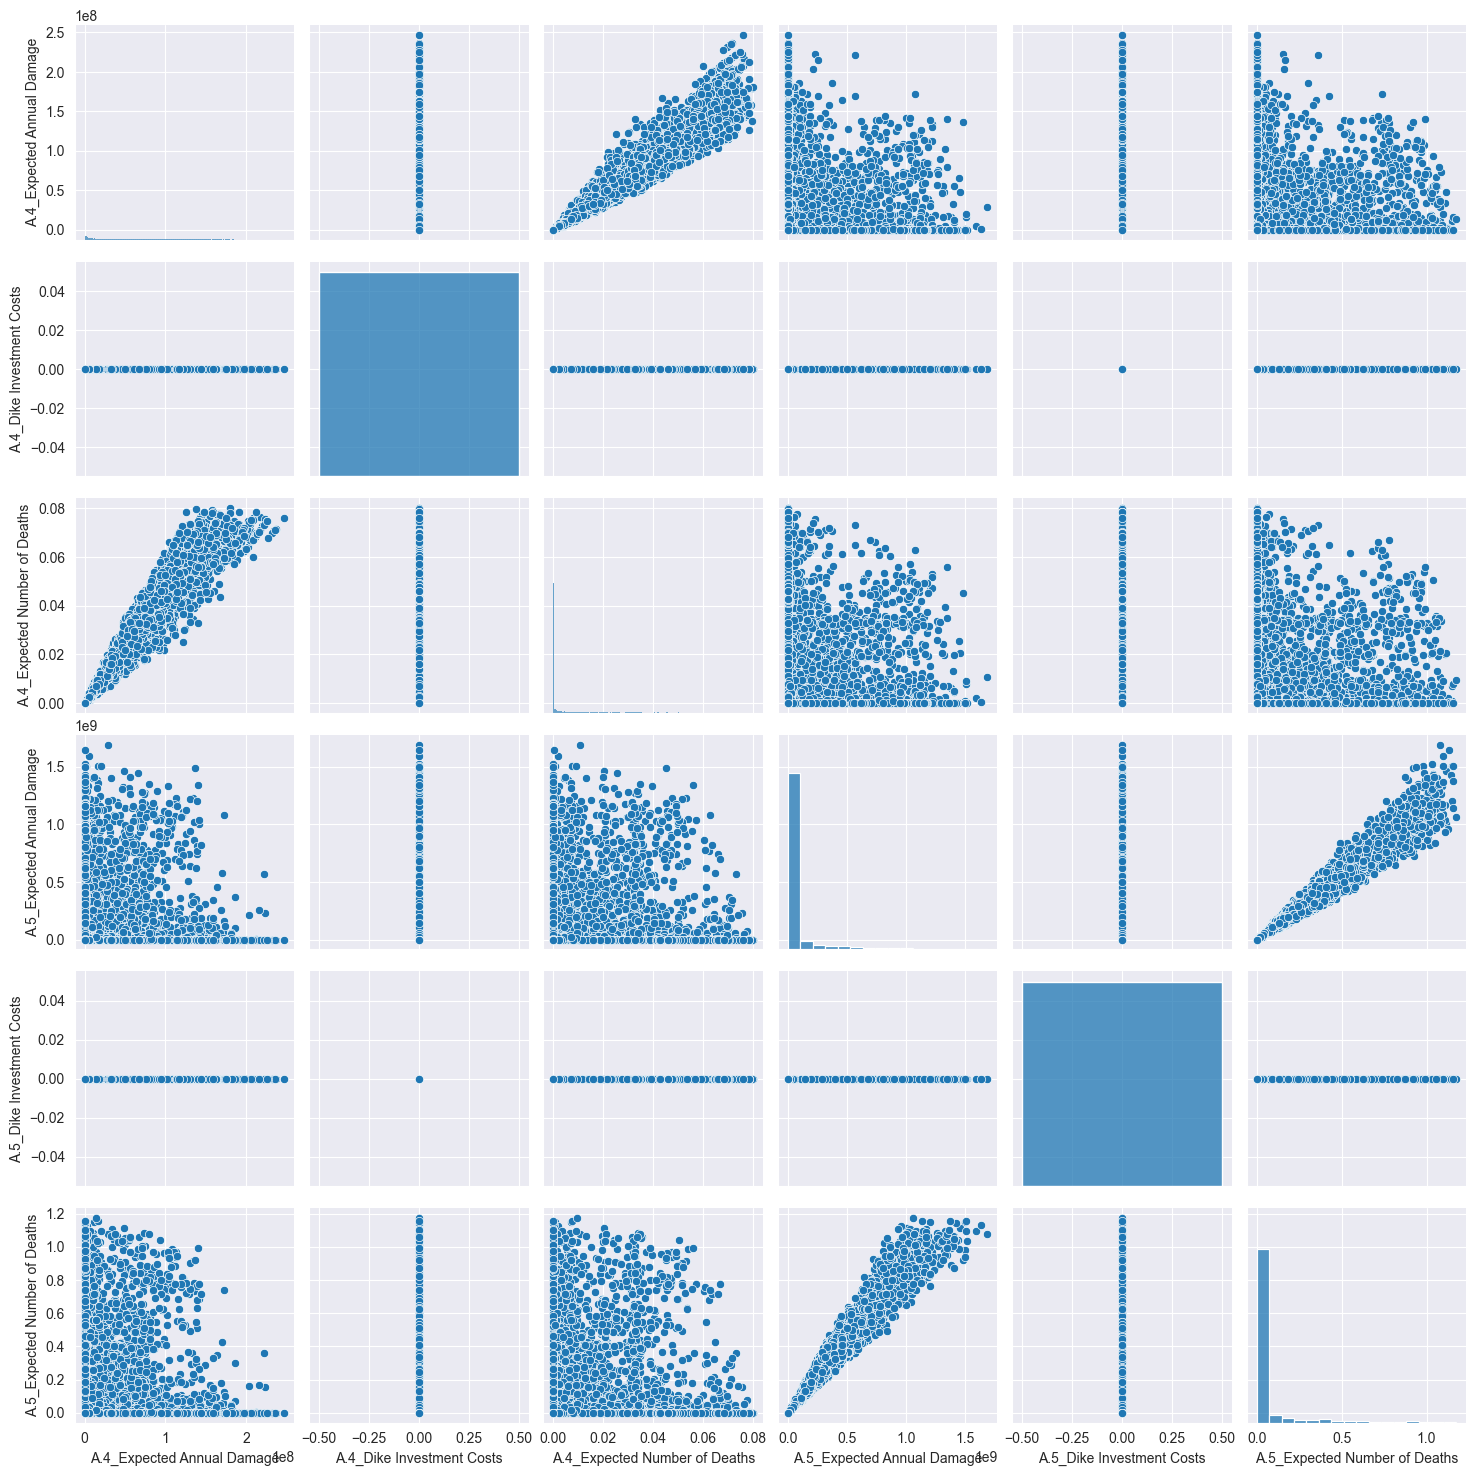

In [6]:
# Create multi scatter plot for zero policy
sns.pairplot(no_policy_outcomes_df)
plt.show()

## 2.2. Feature Scoring

In [7]:
# Initialize the dike model from the problem formulation
dike_model, planning_steps = get_model_for_problem_formulation(2)

# Access and print the uncertainties
dike_model_uncertainties = dike_model.uncertainties

# Create a list of uncertainty names
uncertainties = []

# Print out each uncertainty in the list
for uncertainty in dike_model_uncertainties:
    uncertainties.append(uncertainty.name)
    
print(uncertainties)  

['discount rate 0', 'discount rate 1', 'discount rate 2', 'A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_pfail', 'A.1_Brate', 'A.2_Bmax', 'A.2_pfail', 'A.2_Brate', 'A.3_Bmax', 'A.3_pfail', 'A.3_Brate', 'A.4_Bmax', 'A.4_pfail', 'A.4_Brate', 'A.5_Bmax', 'A.5_pfail', 'A.5_Brate']


In [8]:
no_policy_experiments_uncertainties = no_policy_experiments_df.loc[:,uncertainties]

print(no_policy_experiments_uncertainties)

       discount rate 0  discount rate 1  discount rate 2  \
0                  3.5              3.5              1.5   
1                  4.5              1.5              1.5   
2                  4.5              4.5              3.5   
3                  3.5              1.5              2.5   
4                  3.5              3.5              2.5   
...                ...              ...              ...   
19995              2.5              4.5              3.5   
19996              4.5              2.5              2.5   
19997              3.5              2.5              2.5   
19998              1.5              3.5              3.5   
19999              4.5              2.5              2.5   

       A.0_ID flood wave shape    A.1_Bmax  A.1_pfail  A.1_Brate    A.2_Bmax  \
0                           48  288.845992   0.946632        1.0   34.340992   
1                           67  291.822171   0.431515        1.0   82.201366   
2                           48  105.889

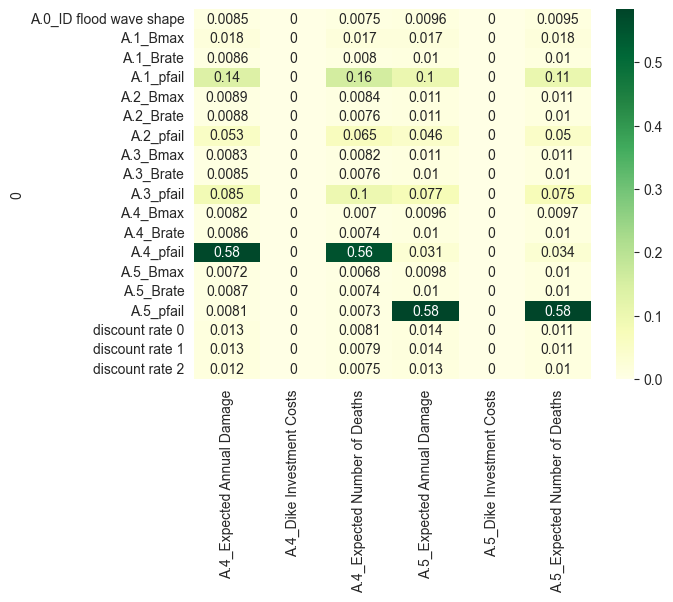

In [9]:
# Let us now calculate the feature scores for the different uncertainties, and their impact on the outcomes of interest
feature_scores = feature_scoring.get_feature_scores_all(no_policy_experiments_uncertainties, no_policy_outcomes_df.drop(columns='policy'))
sns.heatmap(feature_scores, cmap="YlGn", annot=True)
plt.show()

## 2.3. Dimensional Stacking

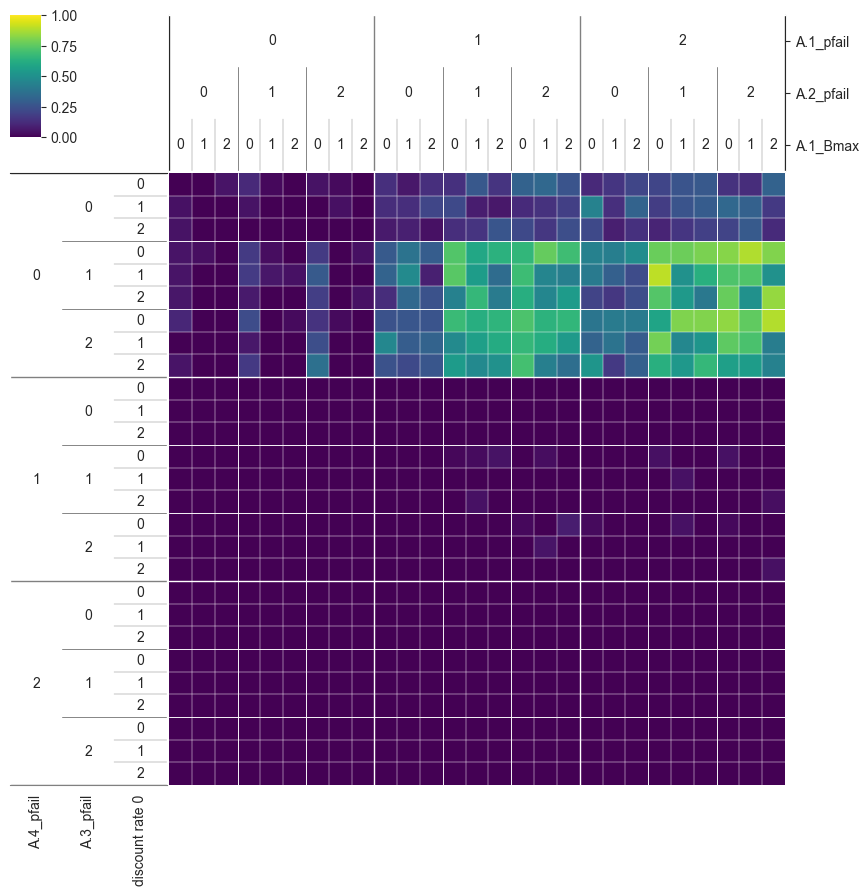

In [10]:
x_no_policy = no_policy_experiments_uncertainties
y_no_policy = no_policy_outcomes_df['A.4_Expected Annual Damage'].values > np.percentile(no_policy_outcomes_df['A.4_Expected Annual Damage'],90)

dimensional_stacking.create_pivot_plot(x_no_policy,y_no_policy, nr_levels=3)
plt.show()

## 2.4. PRIM

### Variable 1

In [11]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_no_policy, y_no_policy, threshold=0.4, peel_alpha= 0.1)
box1 = prim_alg.find_box()

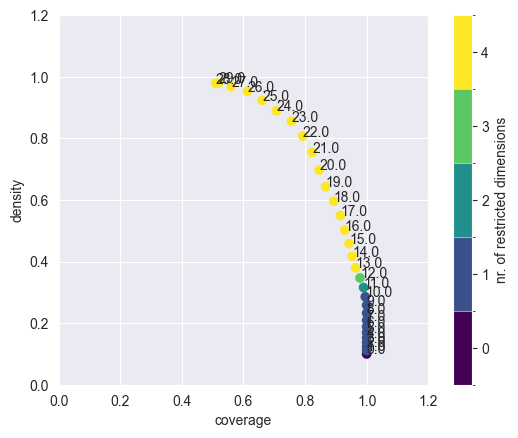

In [12]:
# Let's show the created boxes
box1.show_tradeoff(annotated=True)
plt.show()

In [13]:
# Box X has been selected due to the +/- 80% density
box_number_of_choice = 22
box1.inspect(box_number_of_choice)[0]

coverage       0.793000
density        0.807125
id            22.000000
k           1586.000000
mass           0.098250
mean           0.807125
n           1965.000000
res_dim        4.000000
Name: 22, dtype: float64

             box 22                                  
                min       max       qp value qp value
A.4_pfail  0.000041  0.205705            NaN      0.0
A.1_pfail  0.344416  0.999964  1.212401e-120      NaN
A.3_pfail  0.187539  0.999977   7.548401e-35      NaN
A.2_pfail  0.100296  0.999963   7.100701e-15      NaN


[<Figure size 640x480 with 1 Axes>]

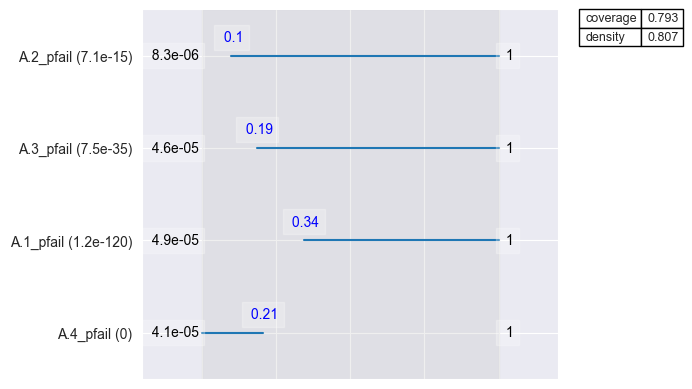

In [14]:
box1.inspect(box_number_of_choice, style="graph")

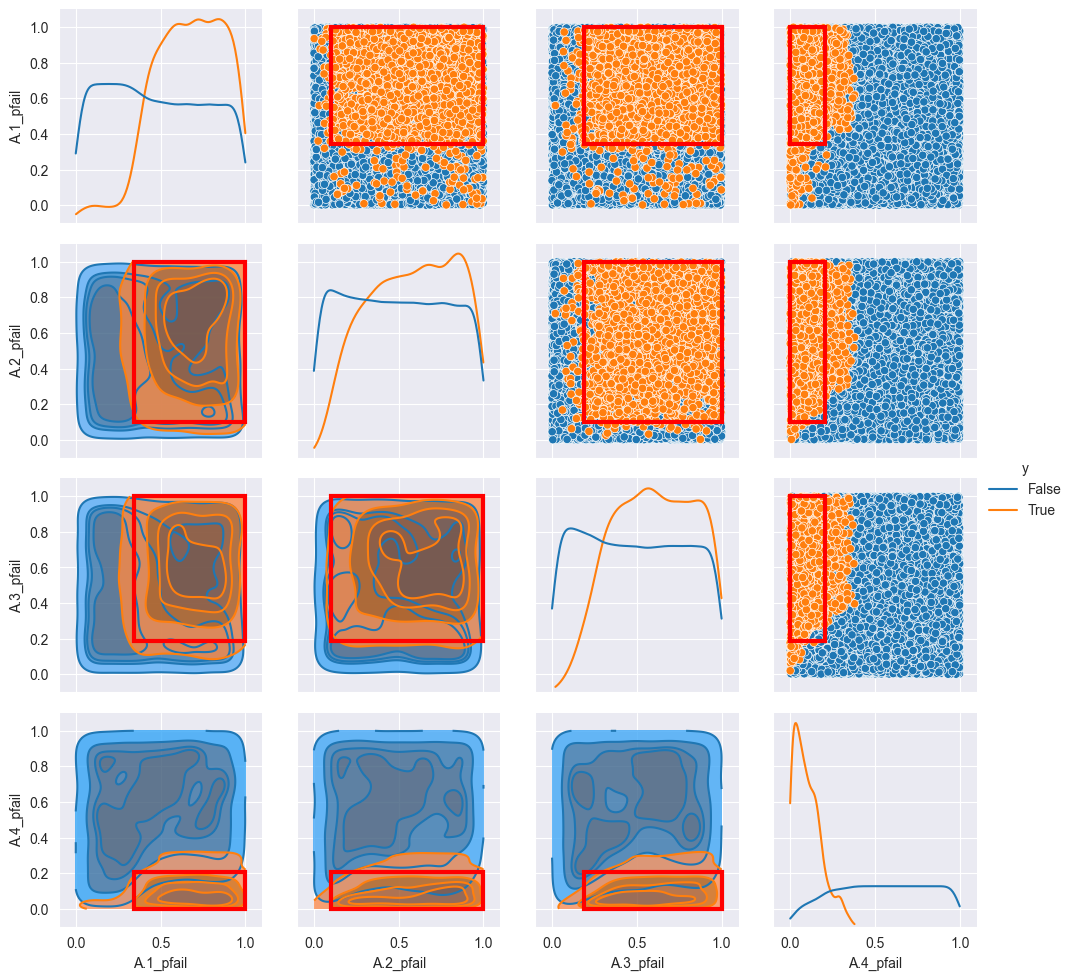

In [15]:
box1.show_pairs_scatter(box_number_of_choice)
plt.show()

#### Let us resample

In [16]:
box1.resample(box_number_of_choice)

reproduce coverage  reproduce density
A.1_pfail                             100.0              100.0
A.2_pfail                             100.0              100.0
A.3_pfail                             100.0              100.0
A.4_pfail                             100.0              100.0
discount rate 0                         0.0                0.0
discount rate 1                         0.0                0.0
discount rate 2                         0.0                0.0
A.0_ID flood wave shape                 0.0                0.0
A.1_Bmax                                0.0                0.0
A.1_Brate                               0.0                0.0
A.2_Bmax                                0.0                0.0
A.2_Brate                               0.0                0.0
A.3_Bmax                                0.0                0.0
A.3_Brate                               0.0                0.0
A.4_Bmax                                0.0                0.0
A.4_Brate                               0.0                0.0
A.5_Bmax                                0.0                0.0
A.5_pfail                               0.0                0.0
A.5_Brate                               0.0                0.0

The first X parameters can exactly reproduce coverage and density, confirming the suggestion of highly significant quasi p values. The third and fourth are also relatively reliable given their values with an average of 90 and 65 for reproducability.  


### Variable 2

# 3. 200 Policy Runs --> Think about which policies (maybe the water board is not open to all policies (do they want RfR, or do they want higher dikes? or both not))

We will now look at 200 different policies under 1,000 different scenarios to create insight into 200,000 potential futures. We will again apply the five different methods, that we used in step 2 above.

## 3.1. Pairplot

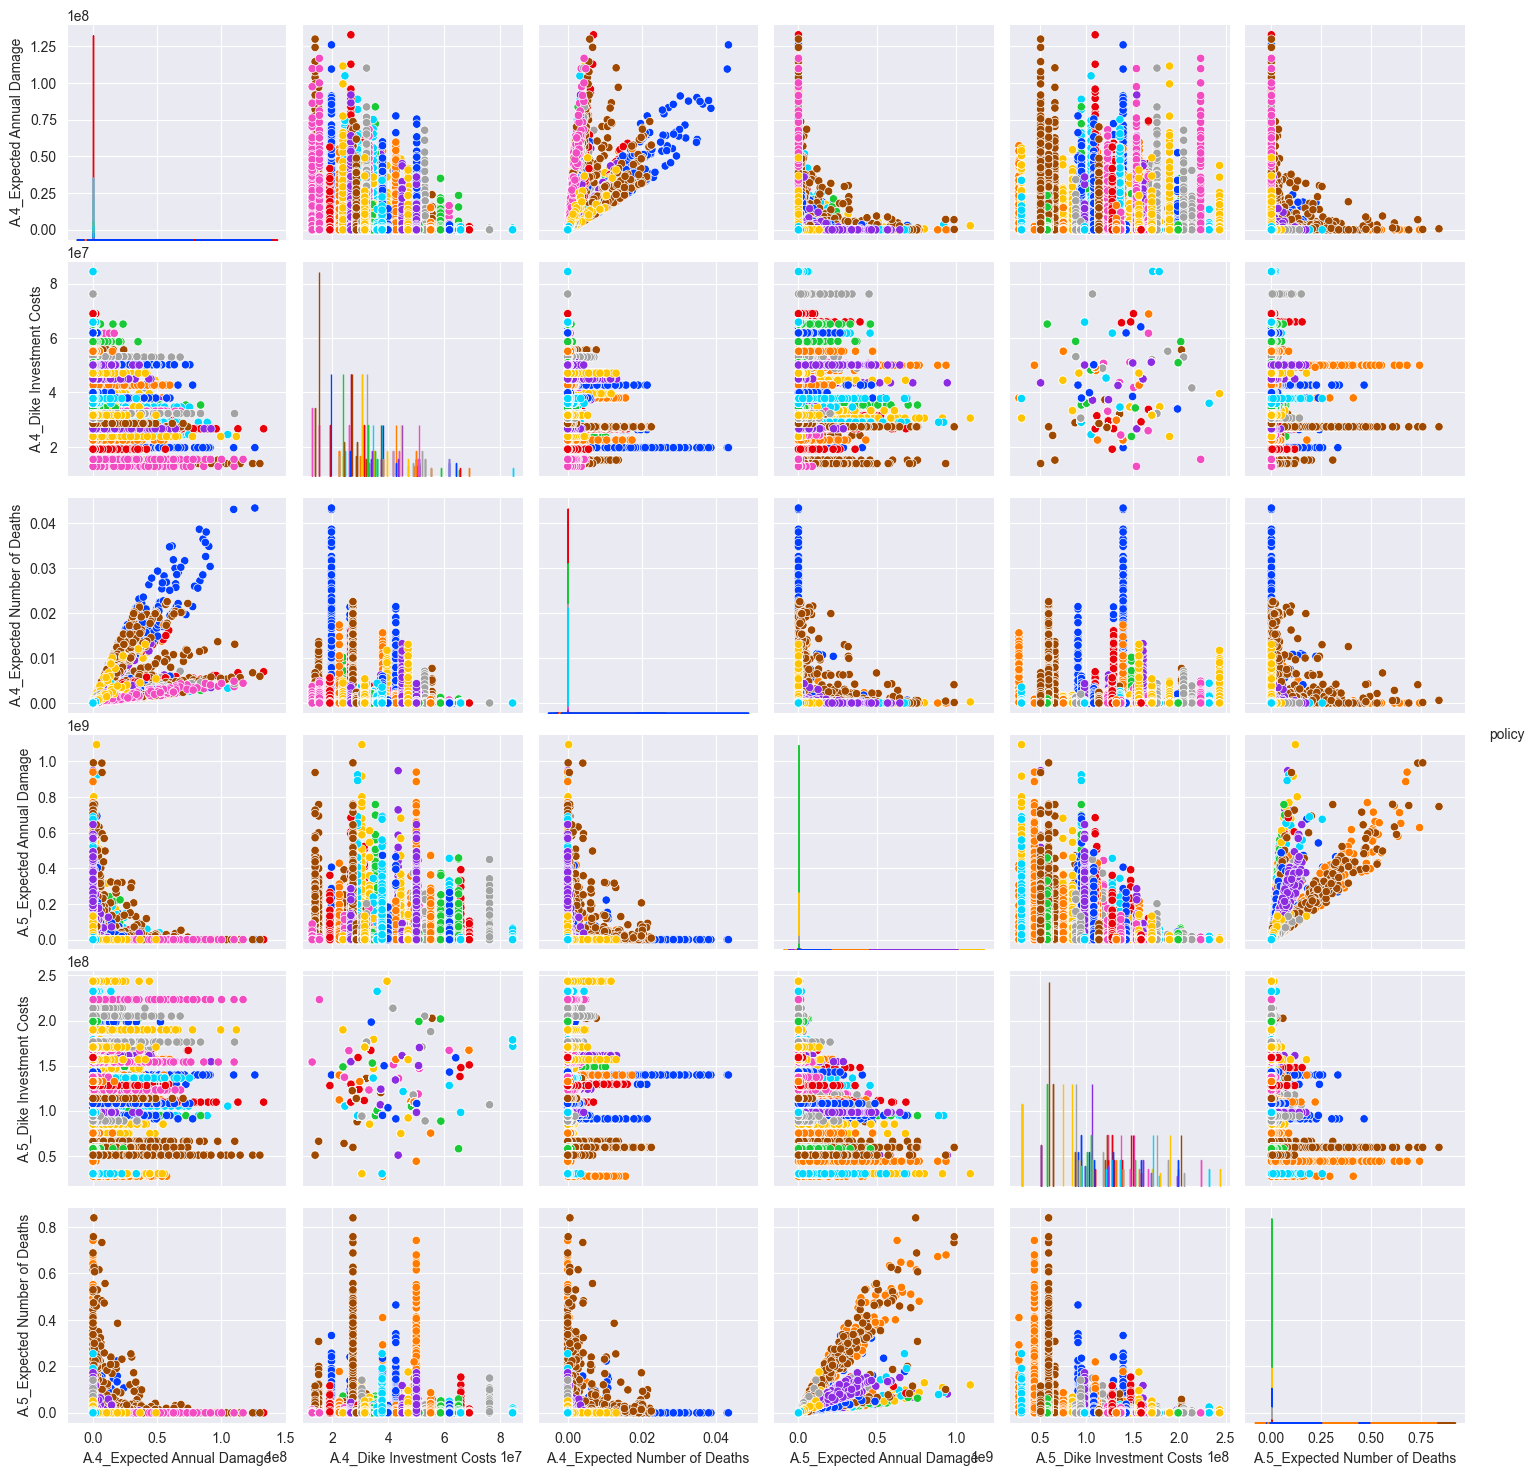

In [17]:
# Create multi scatter plot for zero policy
sns.pairplot(random_outcomes_df, hue='policy', plot_kws={'legend': None}, palette='bright')
plt.legend([], [], frameon=False)  # Hide the legend
plt.show()

## 3.2. Feature Scoring

In [18]:
random_experiments_uncertainties = random_experiments_df.loc[:,uncertainties]

print(random_experiments_uncertainties)

       discount rate 0  discount rate 1  discount rate 2  \
0                  3.5              3.5              4.5   
1                  1.5              4.5              3.5   
2                  3.5              1.5              4.5   
3                  2.5              2.5              4.5   
4                  2.5              2.5              4.5   
...                ...              ...              ...   
99995              4.5              3.5              4.5   
99996              1.5              3.5              4.5   
99997              4.5              1.5              2.5   
99998              1.5              1.5              4.5   
99999              2.5              4.5              2.5   

       A.0_ID flood wave shape    A.1_Bmax  A.1_pfail  A.1_Brate    A.2_Bmax  \
0                          100   99.671347   0.082682       10.0  101.502648   
1                           39  218.736773   0.897241        1.0  131.168565   
2                           91  134.273

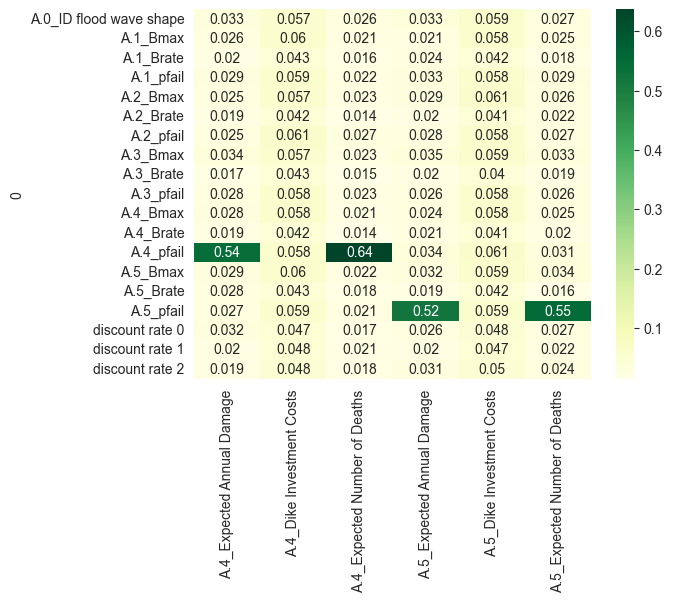

In [19]:
# Let us now calculate the feature scores for the different uncertainties, and their impact on the outcomes of interest
feature_scores = feature_scoring.get_feature_scores_all(random_experiments_uncertainties, random_outcomes_df.drop(columns='policy'))
sns.heatmap(feature_scores, cmap="YlGn", annot=True)
plt.show()

## 3.3. Dimensional Stacking

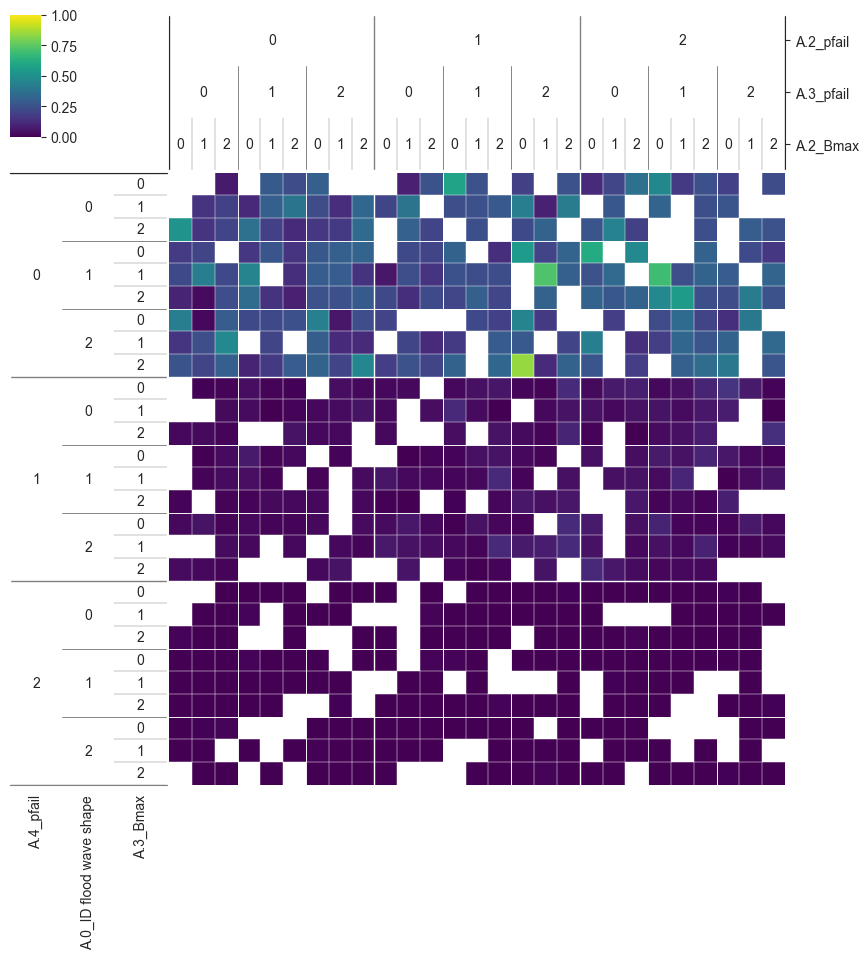

In [20]:
x_random_policy = random_experiments_uncertainties
y_random_policy = random_outcomes_df['A.4_Expected Annual Damage'].values > np.percentile(random_outcomes_df['A.4_Expected Annual Damage'], 90)

dimensional_stacking.create_pivot_plot(x_random_policy,y_random_policy, nr_levels=3)
plt.show()

### Variable 1

In [21]:
# applying PRIM to the 10% worst outcomes for the expected number of deaths (highest number of deaths)
prim_alg = prim.Prim(x_no_policy, y_no_policy, threshold=0.4, peel_alpha= 0.1)
box2 = prim_alg.find_box()

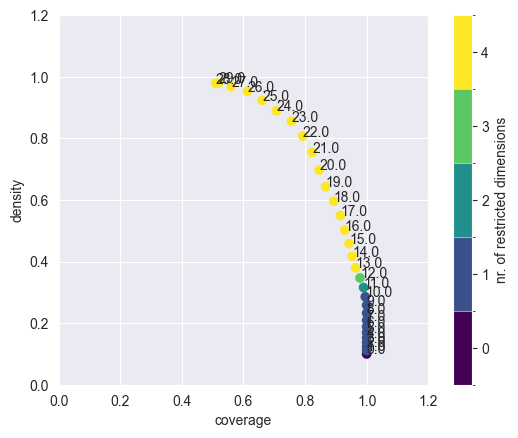

In [22]:
# Let's show the created boxes
box2.show_tradeoff(annotated=True)
plt.show()

[<Figure size 640x480 with 1 Axes>]

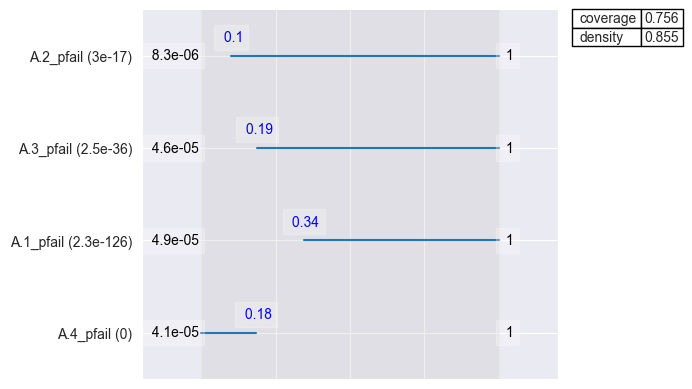

In [23]:
box_number_of_choice = 23
box2.inspect(box_number_of_choice, style="graph")

KeyboardInterrupt: 

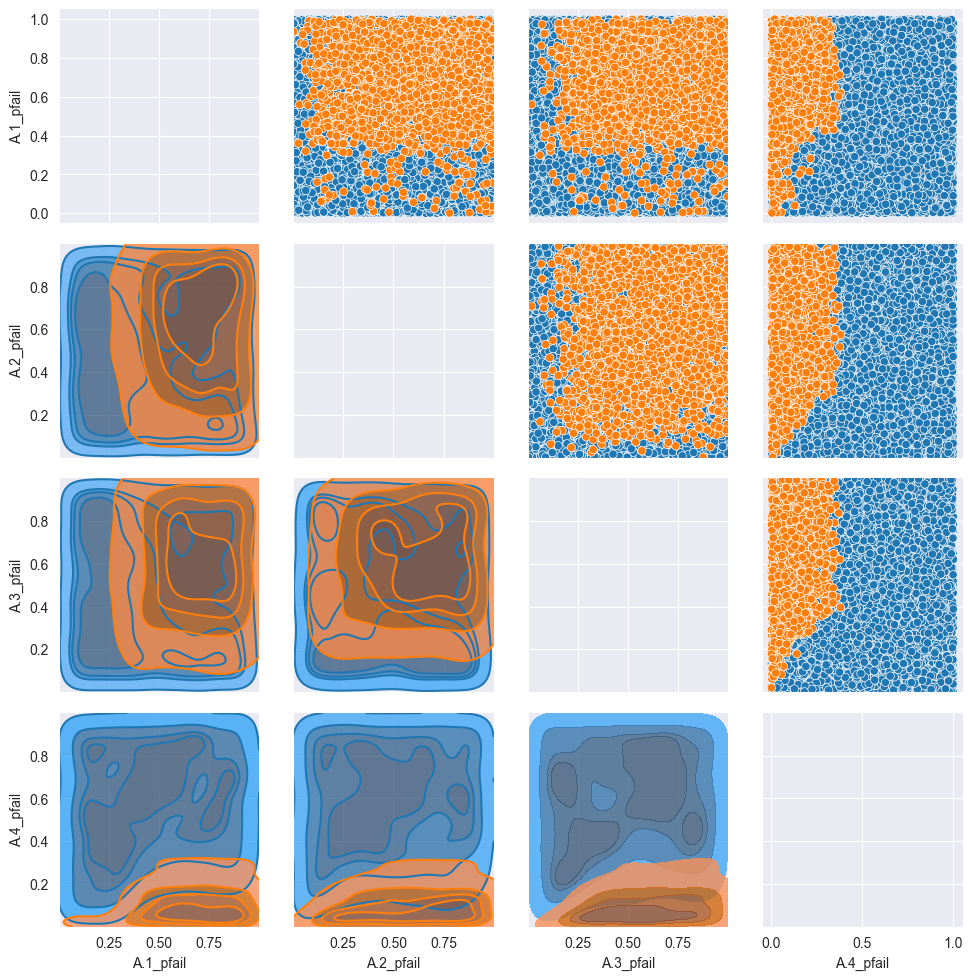

In [24]:
box2.show_pairs_scatter(box_number_of_choice)
plt.show()

#### Let us resample

In [ ]:
box2.resample(box_number_of_choice)

# 4. Sensitivity Analysis

In [25]:
problem = get_SALib_problem(dike_model.uncertainties)
print(problem)

{'num_vars': 19, 'names': ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail', 'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1', 'discount rate 2'], 'bounds': [(0, 133), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (30, 350), (0, 3), (0, 1), (0, 4), (0, 4), (0, 4)]}


In [26]:
print(f"Shape of experiments: {sobol_experiments_df.shape}, Shape of outcomes: {sobol_outcomes_df.shape}")

Shape of experiments: (20600, 53), Shape of outcomes: (20600, 6)


In [27]:
sobol_experiments_uncertainties = sobol_experiments_df.loc[:,uncertainties]

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

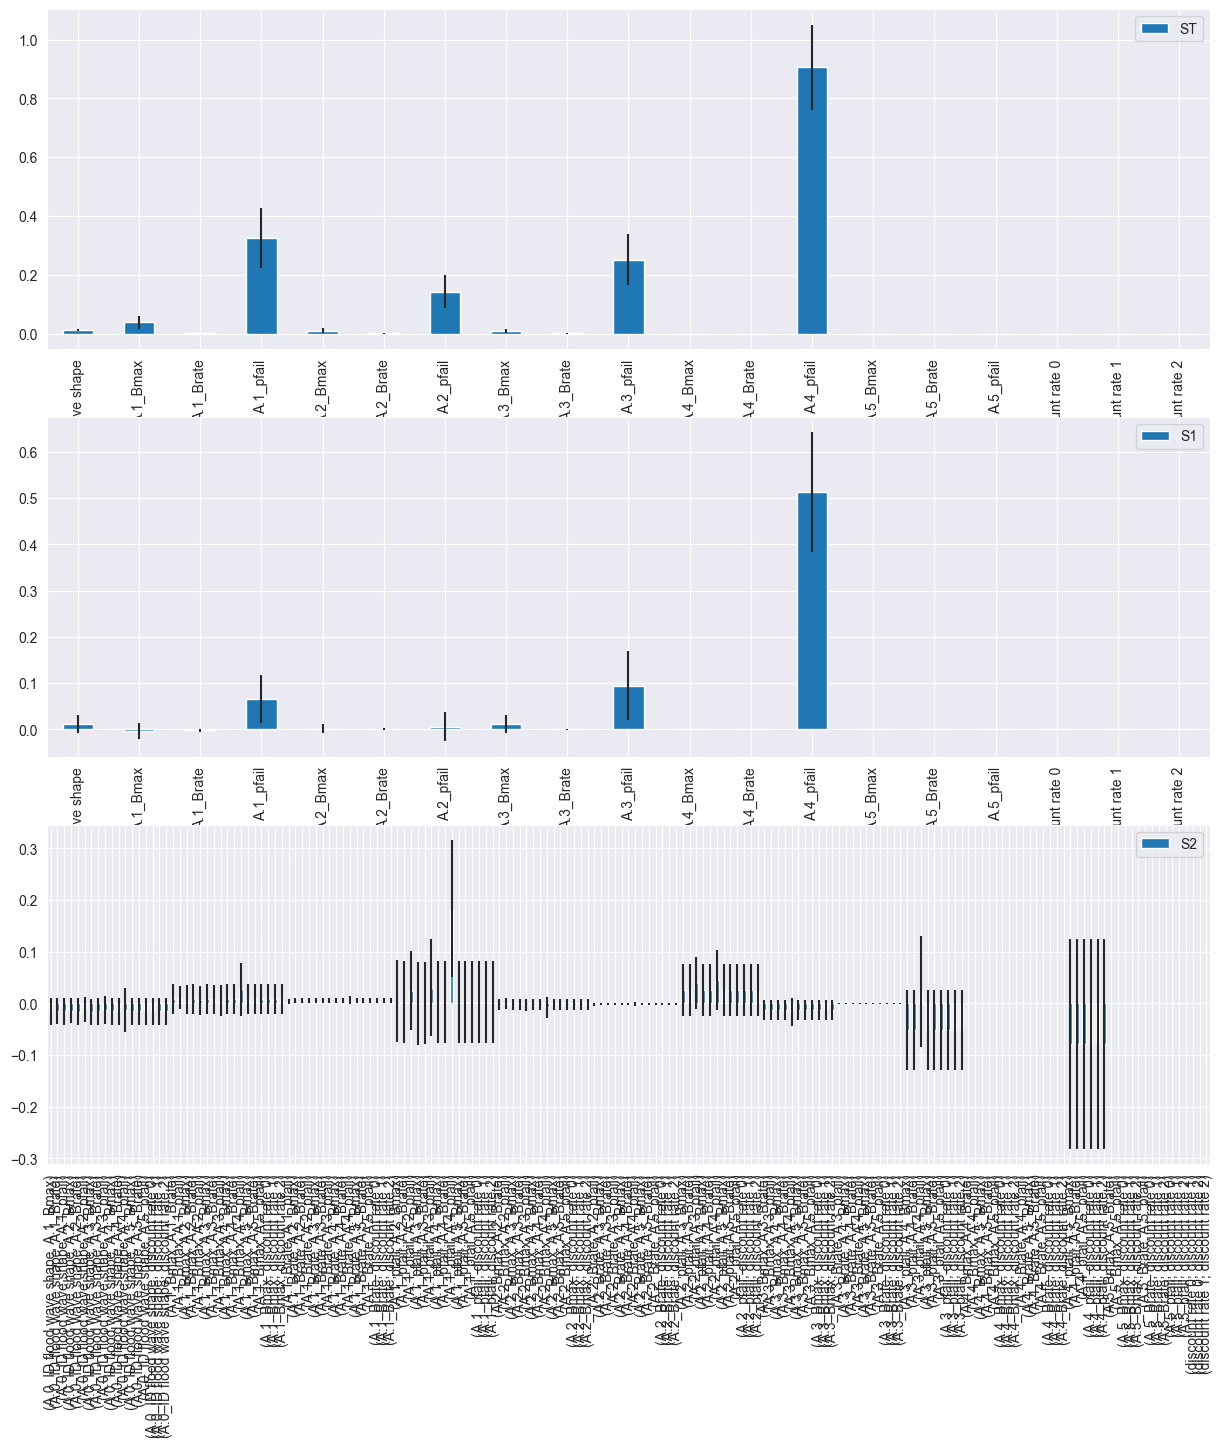

In [28]:
sobol_results = {}

for policy in sobol_experiments_df.policy.unique():
    logical = sobol_experiments_df.policy == policy
    y = sobol_outcomes_df.loc[logical,'A.4_Expected Number of Deaths'].values
    indices = analyze(problem, y)
    sobol_results[policy] = indices

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 15)
indices.plot(ax=axes)

In [29]:
def sobol_sensitivity_analysis(outcome_variable, sobol_outcomes, problem):
    """
    Perform Sobol sensitivity analysis for a specified outcome variable and plot the results.

    Parameters
    ----------
    outcome_variable : str
        The name of the outcome variable to analyze.
    sobol_outcomes : pd.DataFrame
        DataFrame containing the outcomes from the Sobol sensitivity analysis.
    problem : dict
        The problem definition for SALib.
    
    Returns
    -------
    Si : dict
        The Sobol sensitivity indices.
    """
    # Calculate mean and standard deviation for the specified outcome variable
    outcome_value = sobol_outcomes[outcome_variable].values

    # Perform Sobol analysis
    Si = sobol.analyze(problem, outcome_value, calc_second_order=True, print_to_console=True)

    # Filter Sobol indices to relevant metrics
    Si_filter = {k: Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])

    # Plot Sobol indices
    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1', 'ST']]
    err = Si_df[['S1_conf', 'ST_conf']]

    indices.plot.bar(yerr=err.values.T, ax=ax)
    fig.set_size_inches(8, 6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()

    return Si

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.012323  0.003829
A.1_Bmax                 0.038970  0.022905
A.1_Brate                0.000847  0.000583
A.1_pfail                0.326257  0.105607
A.2_Bmax                 0.009011  0.006736
A.2_Brate                0.000133  0.000180
A.2_pfail                0.142812  0.057171
A.3_Bmax                 0.007794  0.006646
A.3_Brate                0.000100  0.000165
A.3_pfail                0.251235  0.087536
A.4_Bmax                 0.000000  0.000000
A.4_Brate                0.000000  0.000000
A.4_pfail                0.905508  0.127245
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.000000  0.000000
discount rate 0          0.000000  0.000000
discount rate 1          0.000000  0.000000
discount rate 2          0.000000  0.000000
                               S1   S1_conf
A.0_ID flood wave shape  0.011361  0.019402
A.1_Bmax                -0.00336

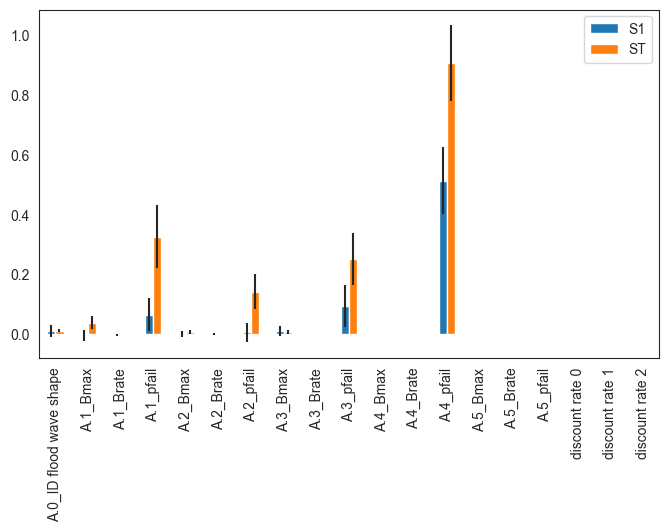

{'S1': array([ 1.13605388e-02, -3.36778440e-03, -2.52085018e-03,  6.54353572e-02,
         1.29623043e-03,  8.81848775e-04,  5.98113282e-03,  1.09734279e-02,
        -1.01234760e-04,  9.43706572e-02,  0.00000000e+00,  0.00000000e+00,
         5.12886413e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]),
 'S1_conf': array([0.0194021 , 0.01844593, 0.00369176, 0.05480212, 0.00891955,
        0.00191349, 0.03090082, 0.0168348 , 0.00061341, 0.07073186,
        0.        , 0.        , 0.11181962, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'ST': array([1.23232888e-02, 3.89696409e-02, 8.46986075e-04, 3.26256524e-01,
        9.01135841e-03, 1.32764763e-04, 1.42811638e-01, 7.79390426e-03,
        1.00489802e-04, 2.51234926e-01, 0.00000000e+00, 0.00000000e+00,
        9.05507606e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 'ST

In [30]:
outcome_variable = 'A.4_Expected Number of Deaths'
sobol_sensitivity_analysis(outcome_variable, sobol_outcomes_df, problem)

C:\Users\jaspe\PycharmProjects\MBDM assignments\MBDM-project\.venv\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


                               ST   ST_conf
A.0_ID flood wave shape  0.010533  0.003424
A.1_Bmax                 0.046570  0.025051
A.1_Brate                0.000977  0.000680
A.1_pfail                0.309189  0.093977
A.2_Bmax                 0.011101  0.011994
A.2_Brate                0.000124  0.000190
A.2_pfail                0.150927  0.080436
A.3_Bmax                 0.008796  0.011245
A.3_Brate                0.000081  0.000113
A.3_pfail                0.214971  0.085617
A.4_Bmax                 0.000000  0.000000
A.4_Brate                0.000000  0.000000
A.4_pfail                0.960566  0.149889
A.5_Bmax                 0.000000  0.000000
A.5_Brate                0.000000  0.000000
A.5_pfail                0.000000  0.000000
discount rate 0          0.008491  0.002939
discount rate 1          0.009621  0.003855
discount rate 2          0.009965  0.004175
                               S1   S1_conf
A.0_ID flood wave shape  0.007700  0.014351
A.1_Bmax                -0.00507

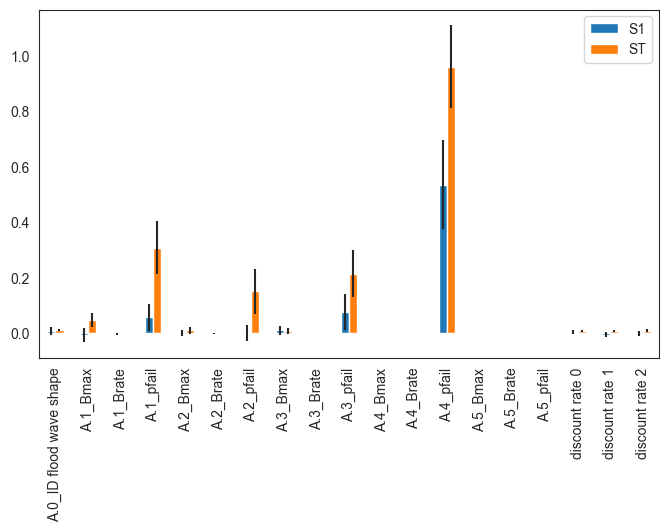

{'S1': array([ 7.69958970e-03, -5.07012151e-03, -2.60642732e-03,  5.72490897e-02,
         1.10165470e-03,  6.16619490e-04,  3.30900830e-04,  1.02473039e-02,
        -6.63345322e-05,  7.64321311e-02,  0.00000000e+00,  0.00000000e+00,
         5.35825914e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.94893990e-03, -5.15227041e-03, -1.96008446e-03]),
 'S1_conf': array([0.01435137, 0.02534469, 0.00392321, 0.04974529, 0.00995932,
        0.00145951, 0.02812665, 0.01608365, 0.00052148, 0.06354106,
        0.        , 0.        , 0.16045746, 0.        , 0.        ,
        0.        , 0.00716902, 0.00923236, 0.00863284]),
 'ST': array([1.05332115e-02, 4.65698953e-02, 9.76978434e-04, 3.09188696e-01,
        1.11011820e-02, 1.23994637e-04, 1.50927023e-01, 8.79565367e-03,
        8.13639479e-05, 2.14971156e-01, 0.00000000e+00, 0.00000000e+00,
        9.60566140e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.49056802e-03, 9.62060104e-03, 9.96511098e-03]),
 'ST

In [31]:
outcome_variable = 'A.4_Expected Annual Damage'
sobol_sensitivity_analysis(outcome_variable, sobol_outcomes_df, problem)